In [54]:
from ultralytics import YOLO
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # For Jupyter notebook progress bar

In [55]:

model_dir = '../../../Train/runs/detect/'

In [56]:
def inference(model_name, video_path):
    df = pd.DataFrame(columns=['frame', 'person'])
    model_path = model_dir + model_name + '/weights/best.pt'
    model = YOLO(model_path)
    # Open video
    cap = cv2.VideoCapture('../' + video_path)
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Prepare DataFrame to store results
    data = []
    
    # Output video writer (optional)# Set up video writer (MP4 format with mp4v codec)
    output_path = 'output_' + model_name + '_' + video_path
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    # Initialize progress bar
    progress = tqdm(total=total_frames, desc="Processing Video", unit="frame")
    
    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
    
        # Run inference
        results = model(frame, verbose=False)
    
        annotated_frame = frame.copy()
        # Count persons
        person_count = 0
        # Draw bounding boxes
        for result in results:
            boxes = result.boxes
            for box in boxes:
                cls = int(box.cls)
                if model.names[cls] == 'person':
                    person_count += 1
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    
        df.loc[len(df)] = [frame_idx, person_count]
        # Display person count
        cv2.putText(annotated_frame, 
                f"Persons: {person_count}", 
                (10, 30),  # Top-left position
                cv2.FONT_HERSHEY_SIMPLEX, 
                1,  # Font scale
                (0, 255, 0),  # Green color
                2,  # Thickness
                cv2.LINE_AA)
        
        # Write frame to output video
        out.write(annotated_frame)
    
        frame_idx += 1
        progress.update(1)  # Update progress bar
    
    # Cleanup
    progress.close()
    cap.release()
    out.release()
    print(f"✅ Saved output video as '{output_path}'")
    return output_path, df

In [57]:
video_path = 'street.mp4'

In [58]:
# Load model
model_name1 = 'person_detect_v1'
output_path1, df1 = inference(model_name1, video_path)

Processing Video:   0%|          | 0/616 [00:00<?, ?frame/s]

✅ Saved output video as 'output_person_detect_v1_street.mp4'


In [59]:
# Load model
model_name2 = 'person_detect_v2'
output_path2, df2 = inference(model_name2, video_path)

Processing Video:   0%|          | 0/616 [00:00<?, ?frame/s]

✅ Saved output video as 'output_person_detect_v2_street.mp4'


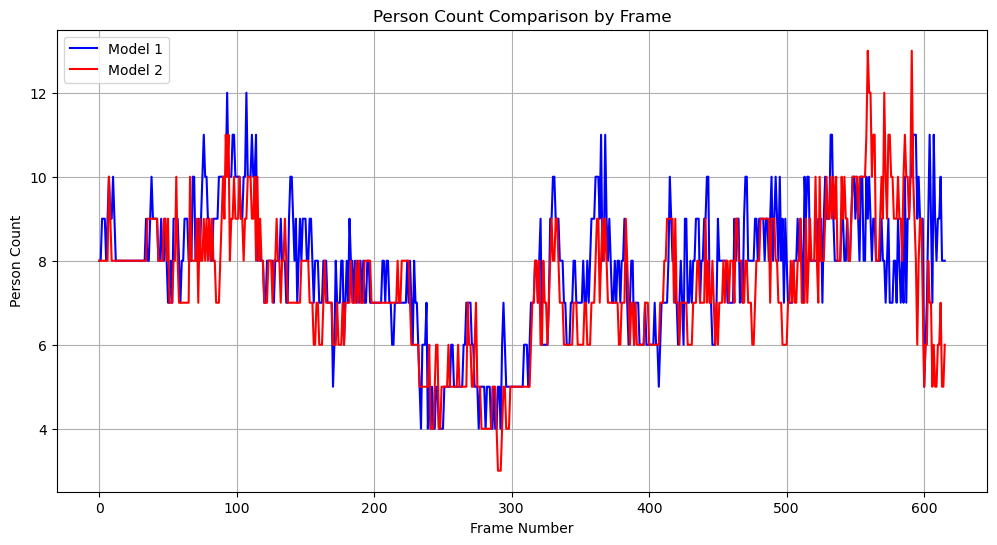

In [60]:
plt.figure(figsize=(12, 6))
plt.plot(df1['frame'], df1['person'], label='Model 1', color='blue')
plt.plot(df2['frame'], df2['person'], label='Model 2', color='red')

plt.title('Person Count Comparison by Frame')
plt.xlabel('Frame Number')
plt.ylabel('Person Count')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
merged_df = pd.merge(
    df1, 
    df2, 
    on='frame', 
    suffixes=('_model1', '_model2')
)
merged_df['delta'] = merged_df['person_model1'] - merged_df['person_model2']

# Sort by largest differences first
sorted_df = merged_df.sort_values('delta', ascending=False)

# Show top 10 frames with biggest discrepancies
top1 = sorted_df.head(5)

print("Top 10 Frames with Largest Count Differences with Model1 Larger:")
print(top1[['frame', 'person_model1', 'person_model2', 'delta']].to_string(index=False))

# Show top 10 frames with biggest discrepancies
top2 = sorted_df.tail(5)
print()
print("Top 10 Frames with Largest Count Differences with Model2 Larger:")
print(top2[['frame', 'person_model1', 'person_model2', 'delta']].to_string(index=False))

Top 10 Frames with Largest Count Differences Model1 Larger:
 frame  person_model1  person_model2  delta
   607             11              6      5
   604             11              7      4
   608              9              5      4
   442             10              7      3
   450              9              6      3

Top 10 Frames with Largest Count Differences Model2 Larger:
 frame  person_model1  person_model2  delta
   591             10             13     -3
   572              7             10     -3
   559              9             13     -4
   571              8             12     -4
   575              7             11     -4


In [77]:
def get_annotated_frame(video_path, frame_idx):
    """
    Opens the video and returns the specified frame (with bounding boxes)
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("❌ Could not open video")
        return None

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print(f"❌ Could not read frame {frame_idx}")
        return None

    # Convert BGR to RGB for matplotlib
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

def plot_frame(frame_idx, output_path1, output_path2):
    # Path to your annotated video
    
    # Get specific frames
    frame1 = get_annotated_frame(output_path1, frame_idx)
    frame2 = get_annotated_frame(output_path2, frame_idx)
    
    # Check if both frames were loaded
    if frame1 is not None and frame2 is not None:
        # Create subplots: 1 row, 2 columns
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
        # Plot frame 101
        axes[0].imshow(frame1)
        axes[0].set_title("Model 1")
        axes[0].axis("off")
    
        # Plot frame 102
        axes[1].imshow(frame2)
        axes[1].set_title("Model 2")
        axes[1].axis("off")
    
        # Adjust layout and show
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ One or more frames could not be retrieved.")

Frame : 607


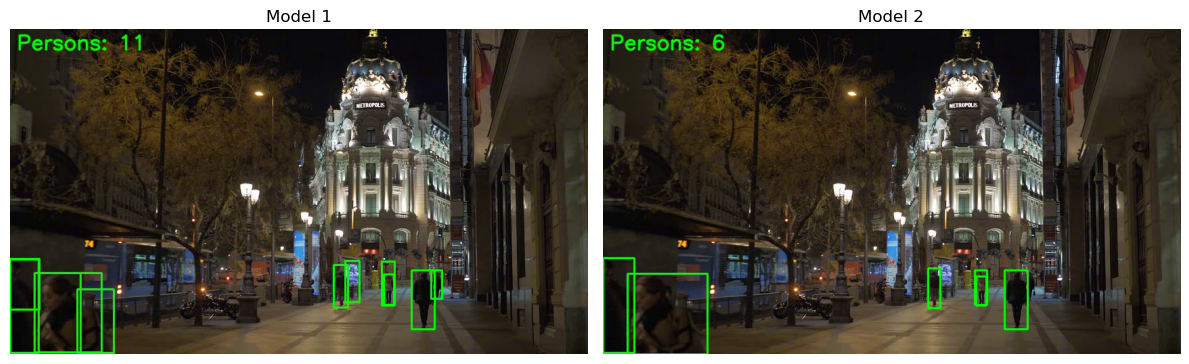

Frame : 604


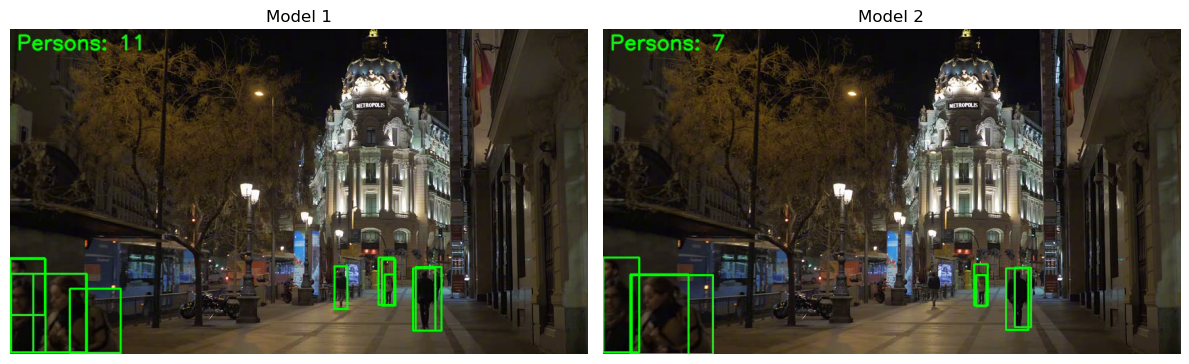

Frame : 608


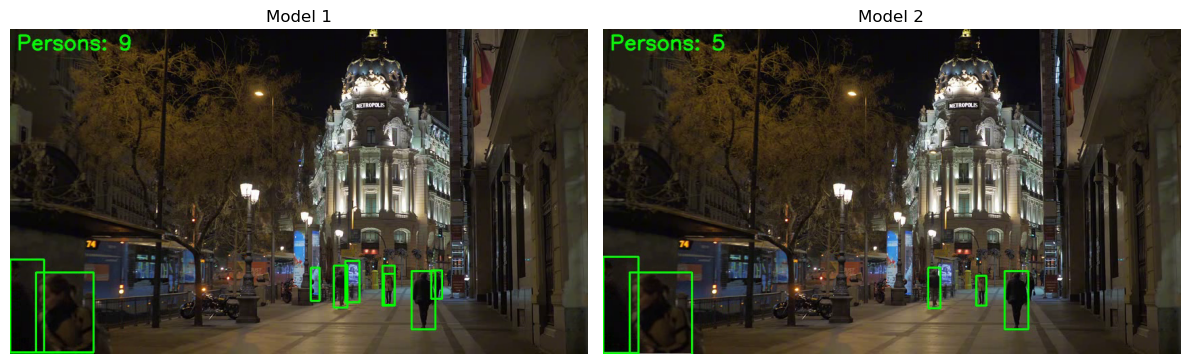

Frame : 442


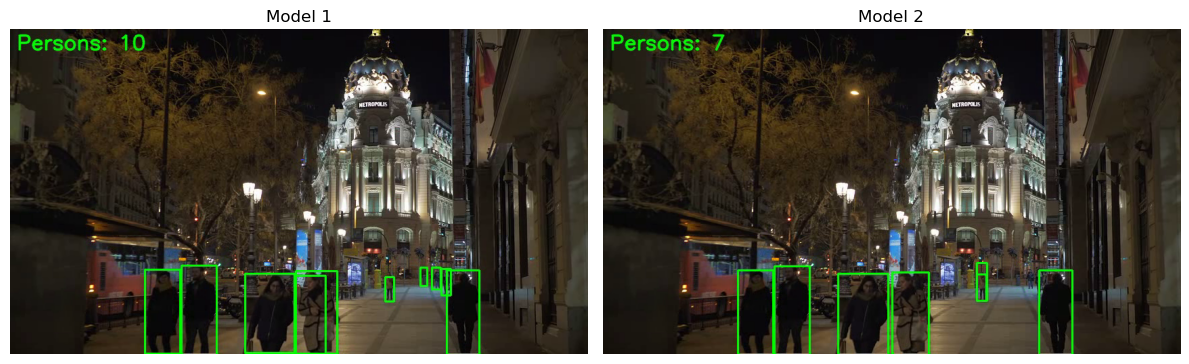

Frame : 450


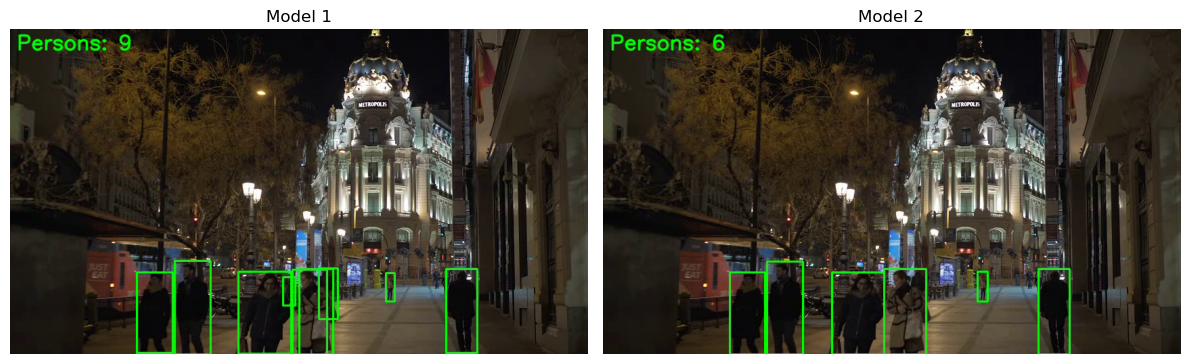

In [87]:
for frame_idx in top1['frame']:
    print(f"Frame : {frame_idx}")
    plot_frame(frame_idx, output_path1, output_path2)

Frame : 591


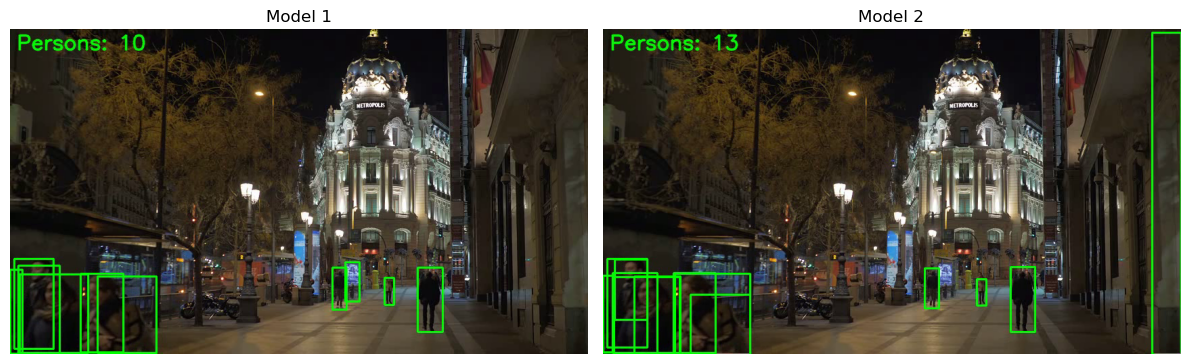

Frame : 572


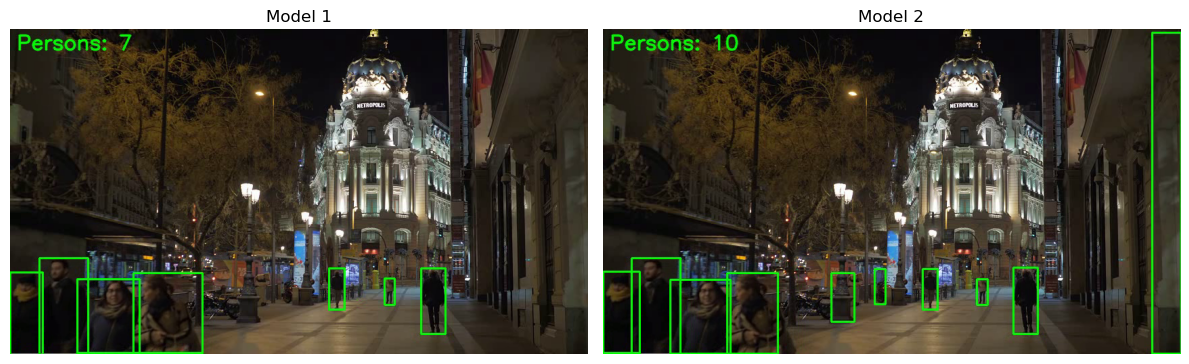

Frame : 559


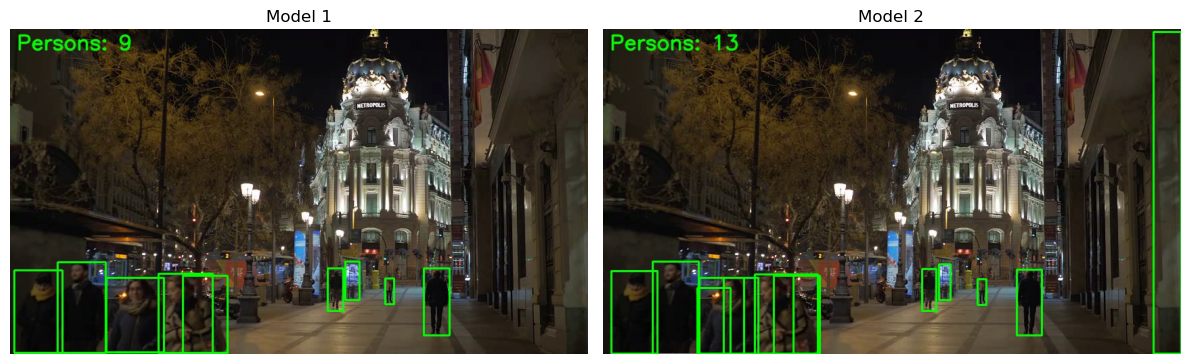

Frame : 571


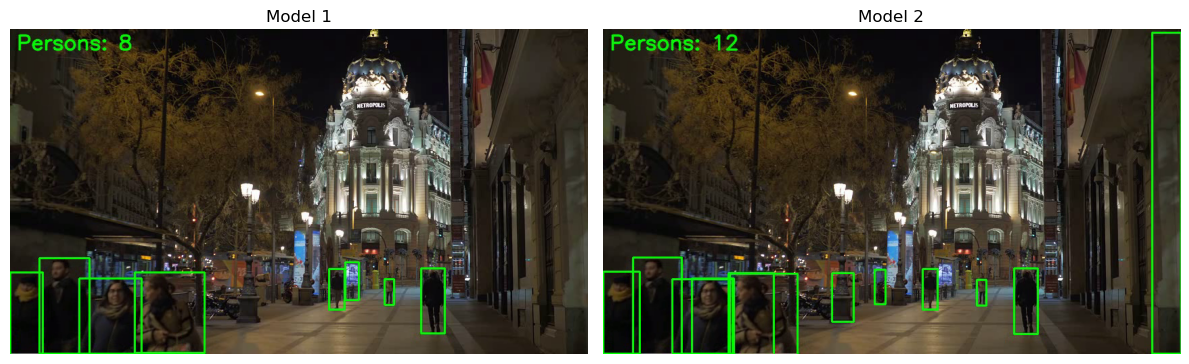

Frame : 575


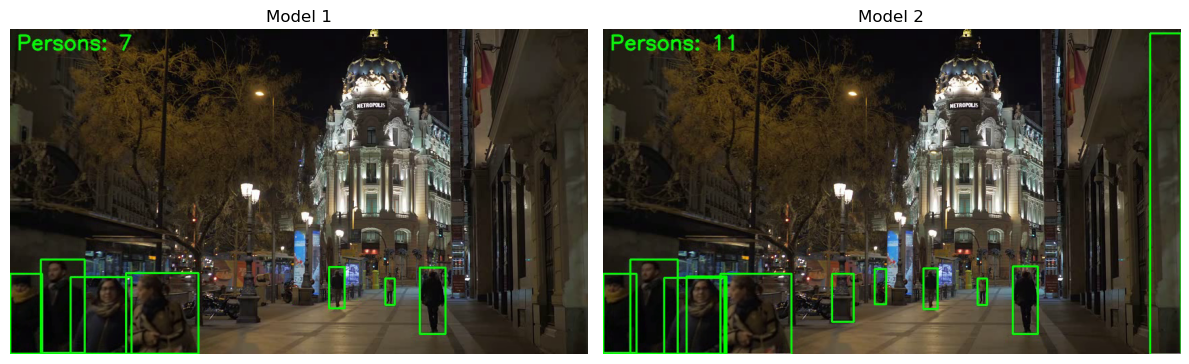

In [88]:
for frame_idx in top2['frame']:
    print(f"Frame : {frame_idx}")
    plot_frame(frame_idx, output_path1, output_path2)